# Basic demo of training GNN on boid model.
All the scripts are in **scripts.gnn.gnn** and **scripts.gnn.gnn_definition**.
The scripts build barebone GNN network architecture, handling of discrete data. 
The notebook illustrates training and testing and demos of single-frame prediction.

In [1]:
%load_ext autoreload
%autoreload 2

In [45]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch_geometric.data import Data, Batch, DataLoader
from torch.utils.data import random_split
import torch.nn.functional as functional

from itertools import combinations

In [3]:
import os, sys
script_path = os.path.realpath(os.path.dirname(__name__))
os.chdir(script_path)
sys.path.append("/workspace/collab-environment/scripts/gnn")
sys.path.append("/workspace/collab-environment/collab_env/data/boids")

In [4]:
from scripts.gnn.gnn import train_rules_gnn, plot_log_loss, get_adjcency_from_debug
from scripts.gnn.gnn_definition import GNN, Lazy
from collab_env.data.boids.animal_simulation import visualize_pair,visualize_graph

### 1. Load data

In [5]:
dataset = torch.load('/workspace/collab-environment/collab_env/data/boids/boid_single_species_basic.pt',
                     weights_only = False)
species_configs = torch.load('/workspace/collab-environment/collab_env/data/boids/boid_single_species_basic_config.pt',
                     weights_only = False)

In [6]:
# split data into training set and test set
test_size = int(len(dataset)/2)
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(
        dataset, [train_size, test_size],
        generator=torch.Generator().manual_seed(2025)
    )

In [20]:
# create mini-batches
batch_size = 1 
# right now we assume the batch_size = 1, because our real dataset are of different lengths.
# But we can expand to minibatches - except fpr a few specific functions, every function is written with minibatches in mind.
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False)

batch = list(iter(train_loader))[0]
pos, species = batch

print("made", str(len(list(train_loader))), "batches, each of size",  str(batch_size))# 
print("Batch position:", pos.shape)    # [Batch size, Number of boids, coordinates (x,y pos)= 2]
print("Species labels:", species.shape)   # [B, N]
print("\n")

made 25 batches, each of size 1
Batch position: torch.Size([1, 1000, 20, 2])
Species labels: torch.Size([1, 20])




### 2. Train GNN and our lazyGNN
The lazy model only outputs a zero acceleration at all frames.

In [8]:
# Specify various model configurations
models = {}

models["vpluspplus_a"] = {}
models["vpluspplus_a"]["node_feature_function"] = "vel_plus_pos_plus" # features are velocity(t-2), velocity(t-1), velocity(t)
models["vpluspplus_a"]["node_prediction"] = "acc" #predict model acceleration
models["vpluspplus_a"]["prediction_integration"] = "Euler" #predict model acceleration
models["vpluspplus_a"]["input_differentiation"] = "finite"
models["vpluspplus_a"]["in_node_dim"] = 6 + 6 + 6 + 1
models["vpluspplus_a"]["start_frame"] = 3
models["vpluspplus_a"]["lr"] = 1e-4

models["lazy"] = {}
models["lazy"]["prediction_integration"] = "Euler" #predict model acceleration
models["lazy"]["input_differentiation"] = "finite"
models["lazy"]["in_node_dim"] = 3
models["lazy"]["lr"] = None

In [99]:
for m in models:

    (node_feature_function, node_prediction,
     input_differentiation, prediction_integration,
     in_node_dim, start_frame, lr) = (models[m]["node_feature_function"], models[m]["node_prediction"],
                                  models[m]["input_differentiation"],models[m]["prediction_integration"],     
                                  models[m]["in_node_dim"], models[m]["start_frame"], models[m]["lr"])

    # initialize models
    if m == "lazy":
        training = False
        lr = None
        gnn_model = Lazy(model_name = m, 
                         input_differentiation = input_differentiation,
                         prediction_integration = prediction_integration,
                         heads = 1, in_node_dim = in_node_dim)
        epoch_num = 1 #number of training epochs
        
    else:
        training = True
        gnn_model = GNN(model_name = m,
                        node_feature_function = node_feature_function,
                        node_prediction = node_prediction,
                        input_differentiation = input_differentiation,
                        prediction_integration = prediction_integration,
                        start_frame = start_frame,
                        heads = 1, in_node_dim = in_node_dim)

        epoch_num = 5 #number of training epochs
    
    visual_range = 0.5 #visual range

    # train models
    (models[m]["train_losses"], models[m]["model"],
     models[m]["debug_result"]
     ) = train_rules_gnn(
                        gnn_model,
                        train_loader,
                        visual_range = visual_range,
                        epochs = epoch_num,
                        lr = lr,
                         training = training,
                         species_dim = len(torch.unique(species)),
                         device=None)
    
    models[m]["W_input"], models[m]["W_output"] = get_adjcency_from_debug(
        models[m]["debug_result"], train_loader, visual_range)
    

epoch 0


batch 0




/workspace/collab-environment/scripts/gnn/gnn.py:228: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_minushalf = torch.tensor(v_minushalf).to(device)
/workspace/collab-environment/scripts/gnn/gnn.py:180: RuntimeWarning: invalid value encountered in divide
  A_output = A / col_sum[np.newaxis, :]


batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


Epoch 000 | Train: 0.0006
finished one epoch


In [100]:
# save model
for m in ['vpluspplus_a','lazy']:
    gnn_model = models[m]["model"]
    model_output = "collab_env/trained_models/boid_single_species_basic_nonlinearfeature.pt"
    torch.save(gnn_model.state_dict(), model_output)

### 3. Investigate loss 

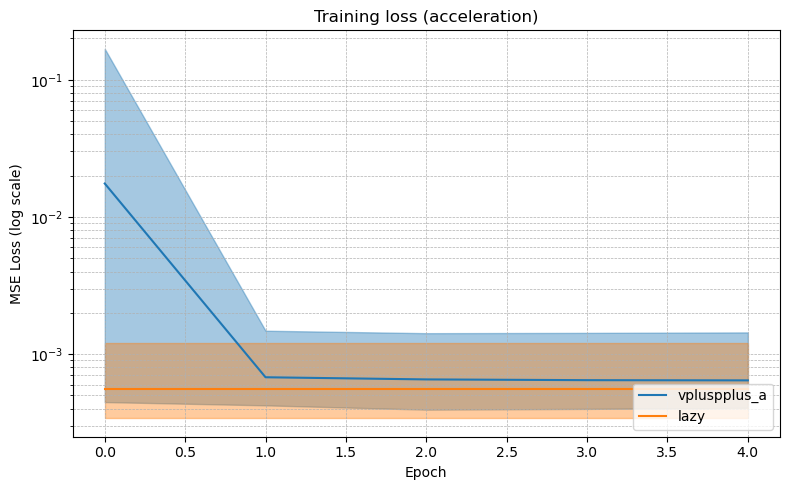

In [106]:
loss_all = [models[m]["train_losses"] for m in ['vpluspplus_a']]

loss_all.append(np.tile(models['lazy']["train_losses"], (loss_all[0].shape[0],1)))

plot_log_loss(loss_all,[m for m in models],
              alpha = 0.05,
              title = "Training loss (acceleration)")
plt.show()

#loss_all = [models[m]["train_losses"] for m in models]
#plot_log_loss(loss_all,[m for m in models],
#              alpha = 0.05,
#              title = "Training loss")

### MSE on position prediction

In [103]:
# TO DO: move this into a function
loss_mse_all = {}
for m in models:
    loss_m = []
    epoch_num = list(models[m]["debug_result"].keys())[-1]
    
    for file_id in models[m]["debug_result"][epoch_num].keys():

        actual = np.concatenate(models[m]["debug_result"][epoch_num][file_id]["actual"], axis = 0)
        predicted = np.concatenate(models[m]["debug_result"][epoch_num][file_id]["predicted"], axis = 0)

        loss = functional.mse_loss(torch.tensor(actual), torch.tensor(predicted)) #+ 0.1 * torch.sum(edge_weight)
        loss_m.append(loss)
    loss_mse_all[m] = loss_m

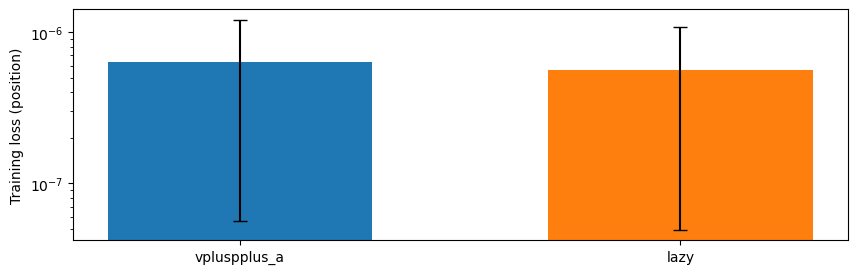

In [107]:
# plot all models
fig, ax = plt.subplots(figsize = (10,3))

ind = 0
for m in models:
    name = m
    mean = np.mean(loss_mse_all[m])
    std_devs = 2 * np.std(loss_mse_all[m])
    ax.bar(ind, mean, width = 0.6)
    ax.errorbar(ind, mean, yerr=std_devs, fmt="none", color='black', capsize=5)
    
    ind += 1
ax.set_xticks(np.arange(len(models)), labels = [m for m in models])
ax.set_ylabel("Training loss (position)")
plt.yscale('log', base = 10)
plt.show()

### To investigate one model on one file

#### a) video, overlay trajectories on top of each other.

In [52]:
epoch_num = 4
file_id = 2
m = "vpluspplus_a"
actual = np.concatenate(models[m]["debug_result"][epoch_num][file_id]["actual"], axis = 0)
predicted = np.concatenate(models[m]["debug_result"][epoch_num][file_id]["predicted"], axis = 0)

actual_acc = np.concatenate(models[m]["debug_result"][epoch_num][file_id]["actual_acc"], axis = 0)
predicted_acc = np.concatenate(models[m]["debug_result"][epoch_num][file_id]["predicted_acc"], axis = 0)

loss_acc = np.array(models[m]["debug_result"][epoch_num][file_id]["loss"])

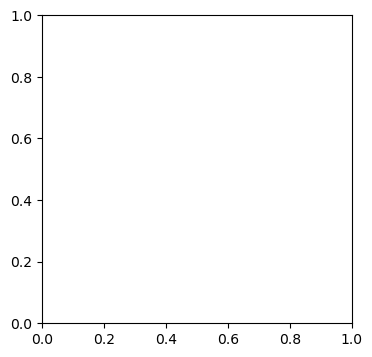

(<matplotlib.animation.FuncAnimation at 0x7ac3a2fba470>, [<Axes: >])

In [58]:
#%matplotlib widget
# This will show a movie of boids, with the actual position in blue and predicted positions in orange.
# need to get matplotlib widget to work in the new conda environment.
visualize_pair(actual, predicted, starting_frame = 600,
               v1 = None, v2 = None)

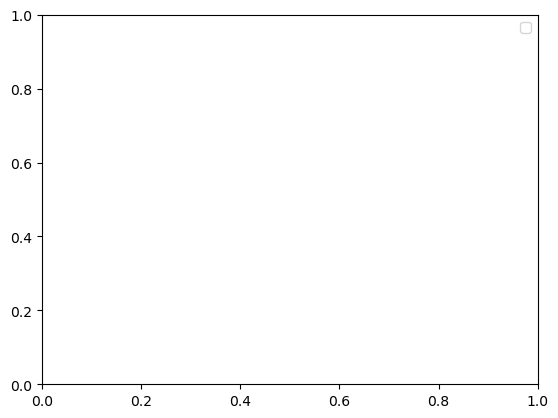

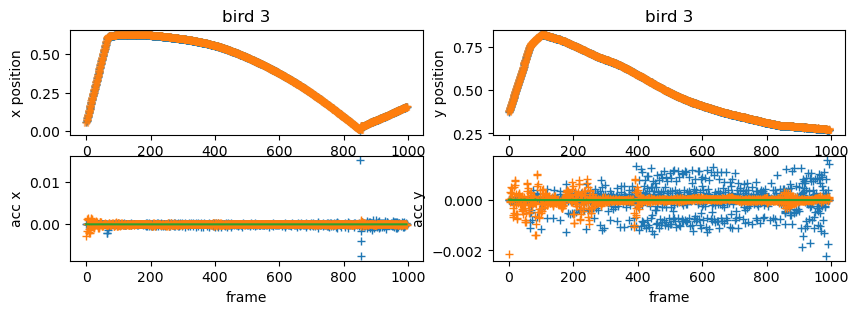

In [65]:
%matplotlib inline
b = 3
fig, ax = plt.subplots(2,2,figsize = (10,3))
ax = ax.ravel()

ax[0].plot(actual[:,b,0],'+',label = "actual")
ax[0].plot(predicted[:,b,0],'*',label = "predicted",alpha = 0.5)
ax[0].set_xlabel('frame')
ax[0].set_ylabel('x position')
ax[0].set_title('bird '+str(b))

ax[1].plot(actual[:,b,1],'+',label = "actual")
ax[1].plot(predicted[:,b,1],'*',label = "predicted",alpha = 0.5)
ax[1].set_xlabel('frame')
ax[1].set_ylabel('y position')
ax[1].set_title('bird '+str(b))

ax[2].plot(actual_acc[:,b,0],'+',label = "actual_acc")
ax[2].plot(predicted_acc[:,b,0],'+',label = "predicted_acc")
ax[2].plot(loss_acc, label = "acc loss")
ax[2].set_xlabel('frame')
ax[2].set_ylabel('acc x')

ax[3].plot(actual_acc[:,b,1],'+',label = "actual_acc")
ax[3].plot(predicted_acc[:,b,1],'+',label = "predicted_acc")
ax[3].plot(loss_acc, label = "acc loss")
ax[3].set_xlabel('frame')
ax[3].set_ylabel('acc y')

plt.show()
plt.legend()

#### b) visualize the dynamic weight matrices
Because the attention layer is a function 
$$A: F \times F \rightarrow \mathbb{R} $$, where $F$ is the space of node feature, a subset of $\mathbb{R}^n$, n is the dimensionality of the input layer size, we obtain dynamic adjacency matrix as boids move around producing dynamic node features.

In [66]:
m = "vpluspplus_a"
W_output = models[m]["W_output"]

In [67]:
# choose a file
file_id = 3

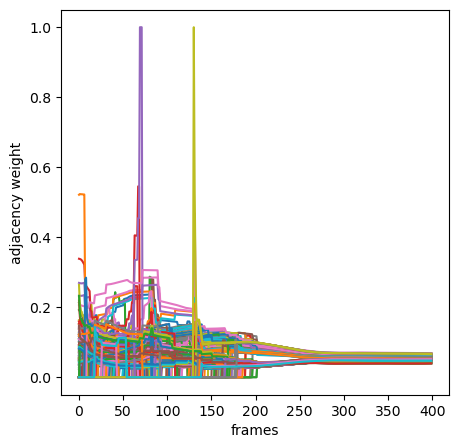

In [68]:
%matplotlib inline

frames = np.arange(0,400)#len(W_output_overtime))
final_epoch = list(W_output.keys())[-1]
W_output_overtime = W_output[final_epoch][file_id]

fig, ax = plt.subplots(1,1,figsize = (5,5))
pairs = combinations(np.arange(np.shape(W_output_overtime[0])[0]), 2)
for p in pairs:
    W_output_overtime_ij = [W_output_overtime[t][p[0],p[1]] for t in frames]
    plt.plot(frames,W_output_overtime_ij)
plt.xlabel("frames")
plt.ylabel("adjacency weight")
plt.show()

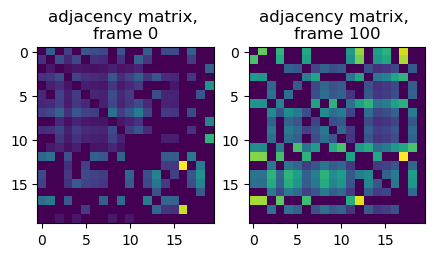

In [79]:
fig, ax = plt.subplots(1,2,figsize = (5,5))
f0 = 0
f1 = 100
ax[0].imshow(W_output_overtime[0])
ax[0].set_title(f"adjacency matrix, \nframe {f0}")
ax[1].imshow(W_output_overtime[100])
ax[1].set_title(f"adjacency matrix, \nframe {f1}")
plt.show()

## 4. Validate on held-out dataset

In [73]:
torch.cuda.empty_cache()

In [74]:
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)
dataloader_list = list(test_loader)
visual_range = 0.5

/workspace/conda/envs/collab-environment/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [108]:
training = False
epoch_num = 1
lr = None

for m in ["lazy"]:#models:

    (node_feature_function, node_prediction,
     input_differentiation, prediction_integration,
     in_node_dim, start_frame) = (models[m]["node_feature_function"], models[m]["node_prediction"],
                                  models[m]["input_differentiation"],models[m]["prediction_integration"],     
                                  models[m]["in_node_dim"], models[m]["start_frame"])

    gnn_model = models[m]["model"]


    # train models
    (models[m]["test_losses"], _,
     models[m]["test_debug_result"]
     ) = train_rules_gnn(
                        gnn_model,
                        test_loader,
                        visual_range = visual_range,
                        epochs = epoch_num,
                        lr = lr,
                         training = training,
                         species_dim = len(torch.unique(species)),
                         device=None)
    
    models[m]["test_W_input"], models[m]["test_W_output"] = get_adjcency_from_debug(
        models[m]["test_debug_result"], test_loader, visual_range)
    

epoch 0


batch 0




/workspace/collab-environment/scripts/gnn/gnn.py:306: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos = torch.tensor(pos)
/workspace/collab-environment/scripts/gnn/gnn.py:307: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vel = torch.tensor(vel)
/workspace/collab-environment/scripts/gnn/gnn.py:308: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  acc = torch.tensor(acc)
/workspace/collab-environment/scripts/gnn/gnn.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.c

batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


Epoch 000 | Train: 0.0005
finished one epoch


### Acceleration loss

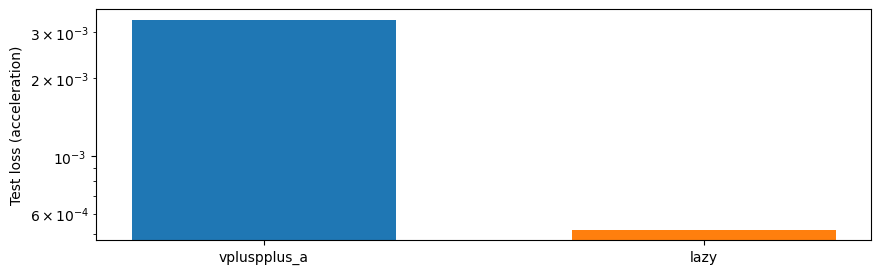

In [111]:
# plot all models
fig, ax = plt.subplots(figsize = (10,3))

ind = 0
for m in models:
    name = m
    mean = np.mean(models[m]["test_losses"])
    std_devs = 2 * np.std(models[m]["test_losses"])
    ax.bar(ind, mean, width = 0.6)
    #ax.errorbar(ind, mean, yerr=std_devs, fmt="none", color='black', capsize=5)
    
    ind += 1
ax.set_xticks(np.arange(len(models)), labels = [m for m in models])
ax.set_ylabel("Test loss (acceleration)")
plt.yscale('log', base = 10)
plt.show()

### MSE position loss

In [112]:
test_loss_mse_all = {}
for m in models:
    loss_m = []
    epoch_num = list(models[m]["test_debug_result"].keys())[-1]
    
    for file_id in models[m]["test_debug_result"][epoch_num].keys():

        actual = np.concatenate(models[m]["test_debug_result"][epoch_num][file_id]["actual"], axis = 0)
        predicted = np.concatenate(models[m]["test_debug_result"][epoch_num][file_id]["predicted"], axis = 0)

        loss = functional.mse_loss(torch.tensor(actual), torch.tensor(predicted)) #+ 0.1 * torch.sum(edge_weight)
        loss_m.append(loss)
    test_loss_mse_all[m] = loss_m

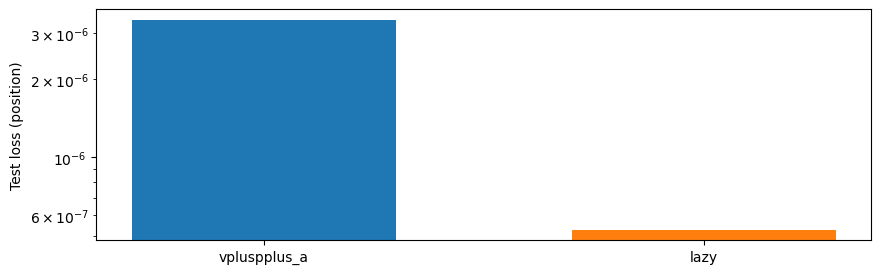

In [113]:
# plot all models
fig, ax = plt.subplots(figsize = (10,3))

ind = 0
for m in models:
    name = m
    mean = np.mean(test_loss_mse_all[m])
    std_devs = 2 * np.std(test_loss_mse_all[m])
    ax.bar(ind, mean, width = 0.6)
    #ax.errorbar(ind, mean, yerr=std_devs, fmt="none", color='black', capsize=5)
    
    ind += 1
ax.set_xticks(np.arange(len(models)), labels = [m for m in models])
ax.set_ylabel("Test loss (position)")
plt.yscale('log', base = 10)
plt.show()